#Feature Selection

Import all the necessary libraries needed to carry out the analysis.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import operator

Open the file with all the comments and data to create a dictionary. Here we use Pickle and PRAW (Python Reddit API Wrapper). 

In [2]:
%%time

import cPickle
import praw

threads = cPickle.load(open('all_comments_dict.p', 'rb'))
print "Number of AskReddit posts: %0.0f" % (len(threads))

Number of AskReddit posts: 100
CPU times: user 1min 14s, sys: 43.8 s, total: 1min 58s
Wall time: 2min 10s


We can see what type of attributes each comment has and an example of how many comments a post can have.

In [3]:
from pprint import pprint
pprint (vars(threads['2rb0pa'][0]))

{'_has_fetched': True,
 '_has_fetched_replies': True,
 '_info_url': u'https://api.reddit.com/api/info/',
 '_replies': [<praw.objects.Comment object at 0x18a1ce410>],
 '_submission': <praw.objects.Submission object at 0x18a171b50>,
 '_underscore_names': [u'replies'],
 '_uniq': None,
 'approved_by': None,
 'archived': True,
 'author': Redditor(user_name='finndre'),
 'author_flair_css_class': None,
 'author_flair_text': None,
 'banned_by': None,
 'body': u'Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf',
 'body_html': u'<div class="md"><p>Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf</p>\n</div>',
 'controversiality': 0,
 'created': 1420430099.0,
 'created_utc': 1420401299.0,
 'distinguished': None,
 'downs': 0,
 'edited': False,
 'gilded': 0,
 'id': u'cnecm22',
 'json_dict': None,
 'likes': None,
 'link_id': u't3_2rb0pa',
 'mod_reports': [],
 'name': u't1_cnecm22',
 'num_reports': None,
 'p

In [4]:
pprint (len(threads['2rb0pa']))

1575


Next, we make a dataframe from all the comments using only the most interesting fields that we believe can later be used for prediction or modeling.

In [5]:
fields = ['_replies',
          '_submission',
          'author',
          'author_flair_css_class',
          'author_flair_text',
          'banned_by',
          'body',
          'body_html',
          'controversiality',
          'created',
          'created_utc',
          'distinguished',
          'downs',
          'edited',
          'gilded',
          'score',
          'score_hidden',
          'subreddit',
          'ups'
         ]

dlist = []
for thread in threads: 
    for comment in threads[thread]:
        temp_d = {}
        temp_d['thread'] = thread
        for field in fields:
            temp_d[field] = comment.__dict__[field]
        dlist.append(temp_d)

df = pd.DataFrame(dlist)

In [6]:
df.head(5)

,_replies,_submission,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,created_utc,distinguished,downs,edited,gilded,score,score_hidden,subreddit,thread,ups
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,None,None,None,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,None,0,False,0,2485,False,AskReddit,36ih74,2485
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,None,None,None,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,None,0,False,1,4983,False,AskReddit,36ih74,4983
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,None,None,None,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,None,0,False,0,2386,False,AskReddit,36ih74,2386
3,"[That sounds painful., Some people just can't ...",4701 :: What is one sentence that people in yo...,cgrosshans,None,None,None,"""Move off that shallow pocket and greasy crimp...","<div class=""md""><p>&quot;Move off that shallow...",0,1432084937,1432056137,None,0,False,0,3197,False,AskReddit,36ih74,3197
4,[Sounds like a good roller disc. ],4701 :: What is one sentence that people in yo...,rottinguy,None,None,None,The disc is so understable I have to put a rid...,"<div class=""md""><p>The disc is so understable ...",0,1432086084,1432057284,None,0,False,0,1438,False,AskReddit,36ih74,1438


#Data Exploration

First let's find some useful information about comments in general, such as average comment length and standard deviation, average number of upvotes and standard deviation, etc. Let's begin with some basic information: 

In [7]:
print "Upvotes mean: %0.2f" % (np.mean(df['ups']))
print "Upvotes median: %0.2f" % (np.median(df['ups']))
print "Upvotes standard deviation: %0.2f" % (np.std(df['ups']))
print "------------------"
print "Gilded mean: %0.2f" % (np.mean(df['gilded']))
print "Gilded median: %0.2f" % (np.median(df['gilded']))
print "Gilded standard deviation: %0.2f" % (np.std(df['gilded']))

Upvotes mean: 80.88
Upvotes median: 2.00
Upvotes standard deviation: 498.15
------------------
Gilded mean: 0.01
Gilded median: 0.00
Gilded standard deviation: 0.11


Let's start by adding the character count for each comment to the dataframe and viewing some relevant statistics.

In [8]:
df['character_count'] = df['body'].map(lambda x : len(x))

In [9]:
print "Length mean: %0.2f" % (np.mean(df['character_count']))
print "Length median: %0.2f" % (np.median(df['character_count']))
print "Length standard deviation: %0.2f" % (np.std(df['character_count']))

Length mean: 196.79
Length median: 93.00
Length standard deviation: 346.24


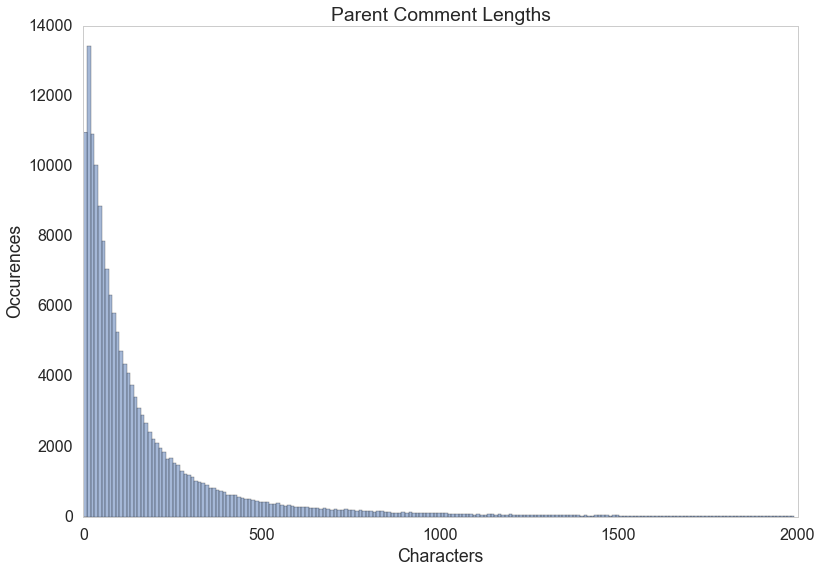

In [10]:
plt.hist(df['character_count'], bins=np.arange(1,2000,10), alpha=0.5, label="Character Lengths");
plt.title('Parent Comment Lengths');
plt.xlabel('Characters');
plt.ylabel('Occurences');
plt.grid(False);

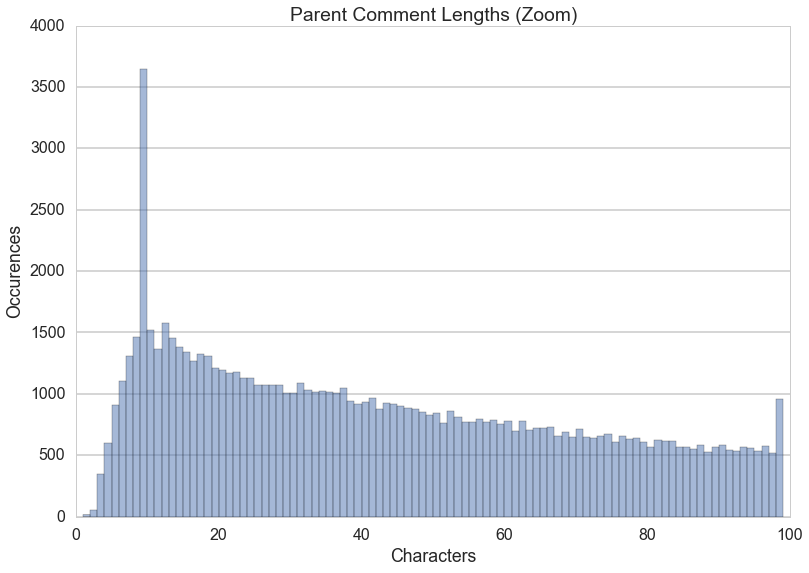

In [11]:
plt.hist(df['character_count'], bins=np.arange(1,100,1), alpha=0.5, label="Character Lengths");
plt.title('Parent Comment Lengths (Zoom)');
plt.xlabel('Characters');
plt.ylabel('Occurences');
ax = plt.gca()
ax.xaxis.grid(False) 

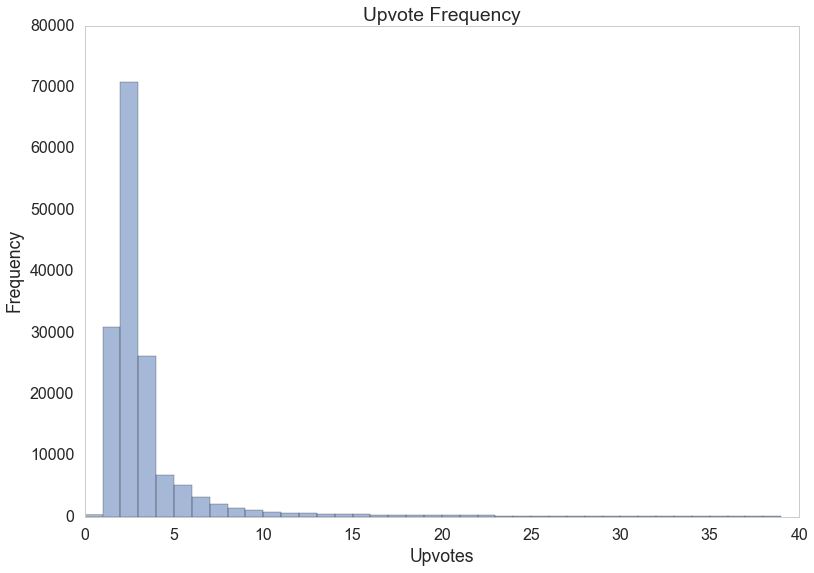

In [12]:
plt.hist(df['ups'], bins=np.arange(0,40,1), alpha=0.5, label="Upvotes");
plt.title('Upvote Frequency');
plt.xlabel('Upvotes');
plt.ylabel('Frequency');
plt.grid(False)

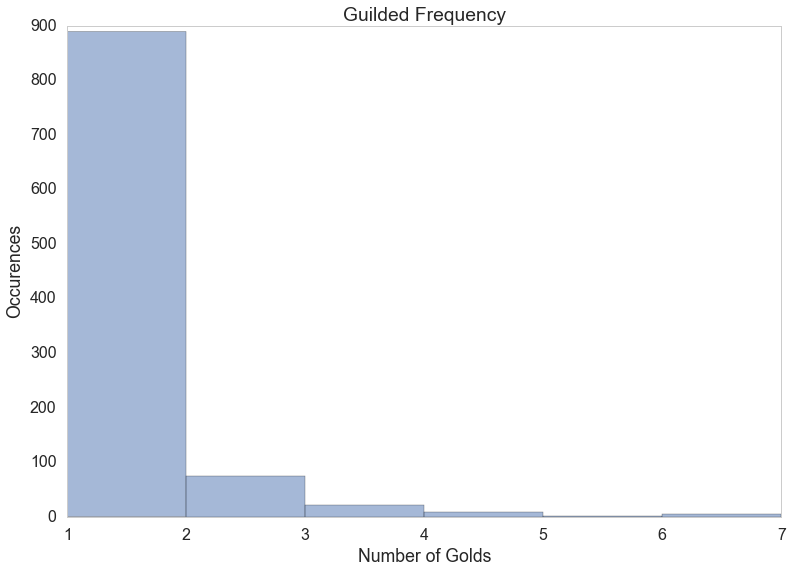

In [13]:
plt.hist(df['gilded'], bins=np.arange(1,8,1), alpha=0.5, label="Gilded");
plt.title('Guilded Frequency');
plt.xlabel('Number of Golds');
plt.ylabel('Occurences');
plt.grid(False)

#Correlations

##Time

First, we can look at the time that a comment is posted and see how that relates to its popularity.

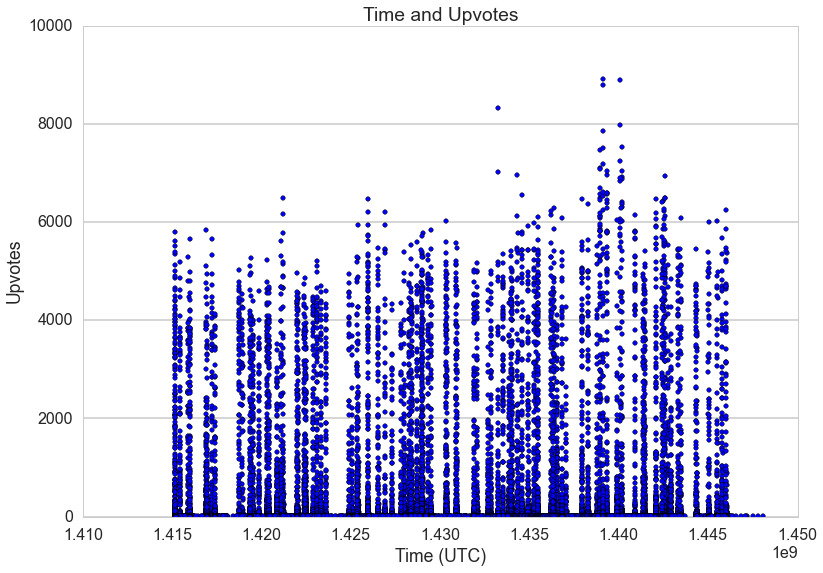

In [15]:
plt.scatter(df['created_utc'], df['ups']);
plt.title('Time and Upvotes');
plt.xlabel('Time (UTC)');
plt.ylabel('Upvotes');
plt.ylim(ymin=-0.1);
ax = plt.gca();
ax.xaxis.grid(False)

The pattern above is fairly interesting. Nearly all the highly upvoted comments appear in a very short span of time, which perhaps leads us to believe that an early comment is more likely to receive more upvotes. 

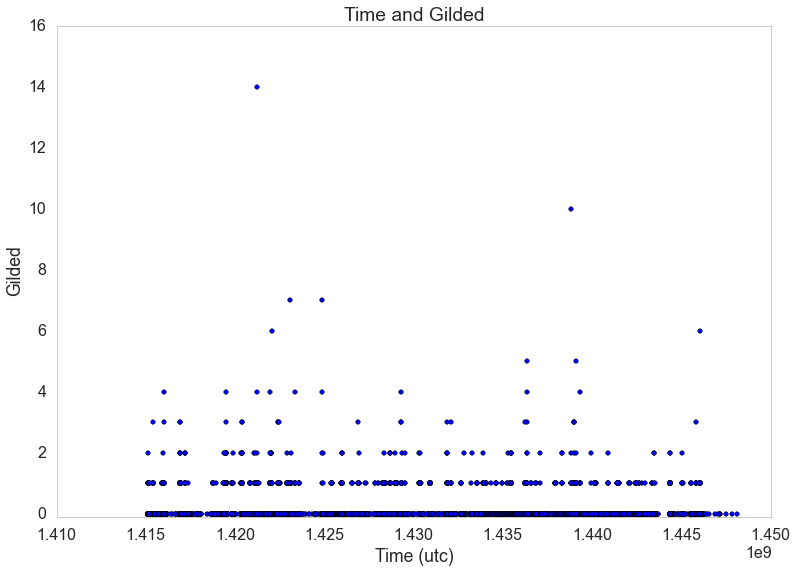

In [16]:
plt.scatter(df['created_utc'], df['gilded']);
plt.title('Time and Gilded');
plt.xlabel('Time (utc)');
plt.ylabel('Gilded');
plt.ylim(ymin=-0.1);
plt.grid(False);

So, let's take a closer look at how the **difference in time** between the initial post and the comment affects its popularity.

In [17]:
df['time_delay'] = df.apply(lambda row : row['created_utc'] - row['_submission'].created_utc, axis=1)

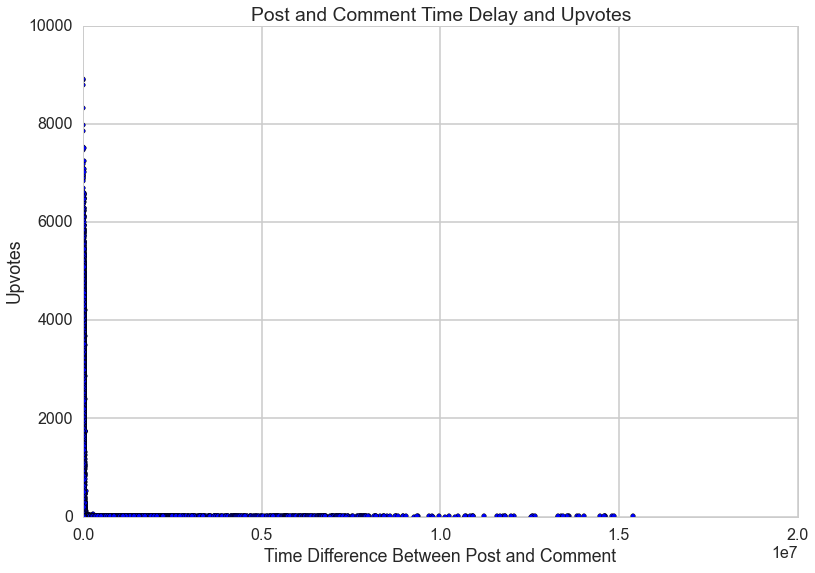

In [18]:
plt.scatter(df['time_delay'], df['ups']);
plt.title('Post and Comment Time Delay and Upvotes');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Upvotes');
plt.ylim(ymin=-0.5);
plt.xlim(xmin=-0.5);

Zooming in toward the quicker commenters reveals an interesting pattern below. 

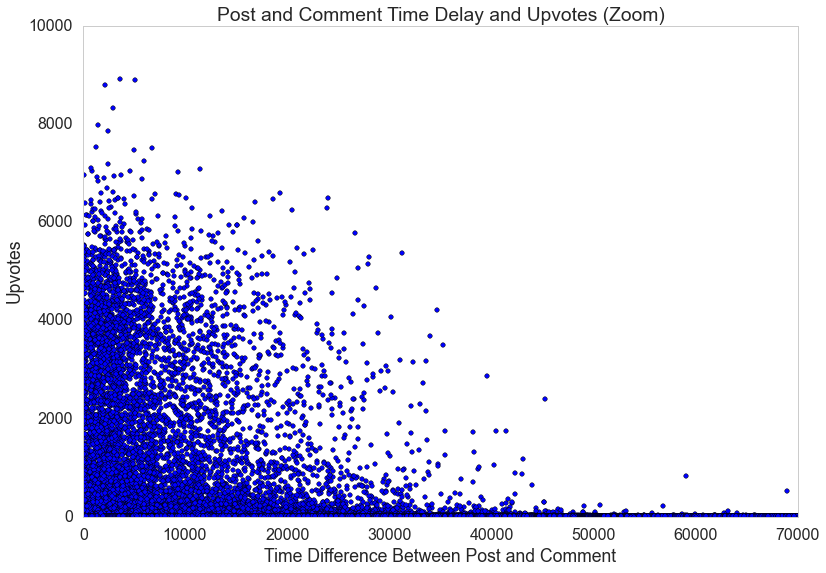

In [19]:
plt.scatter(df['time_delay'], df['ups']);
plt.xlim(0,70000);
plt.ylim(ymin=-0.5)
plt.title('Post and Comment Time Delay and Upvotes (Zoom)');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Upvotes');
plt.grid(False);

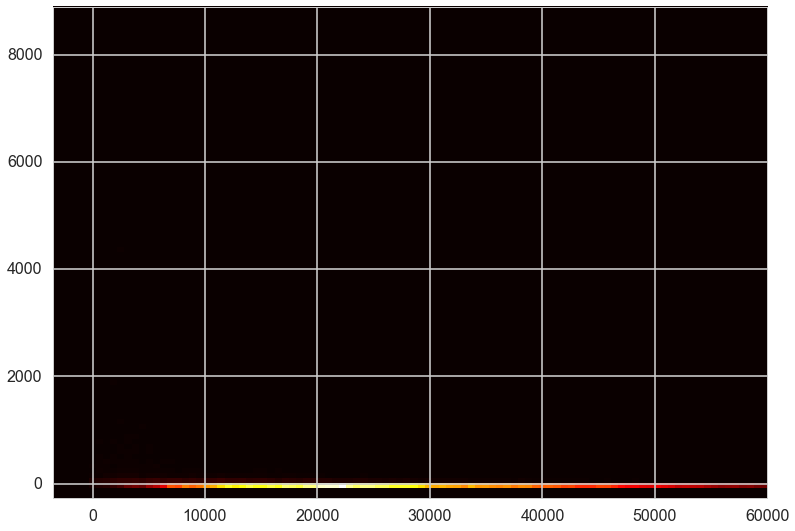

In [20]:
temp = df[(df.time_delay<60000)][['time_delay', 'ups']]
plt.hist2d(temp['time_delay'], temp['ups'], bins=100, cmap='hot');

A similar thing can be down for being gilded and quickness of commenting. 

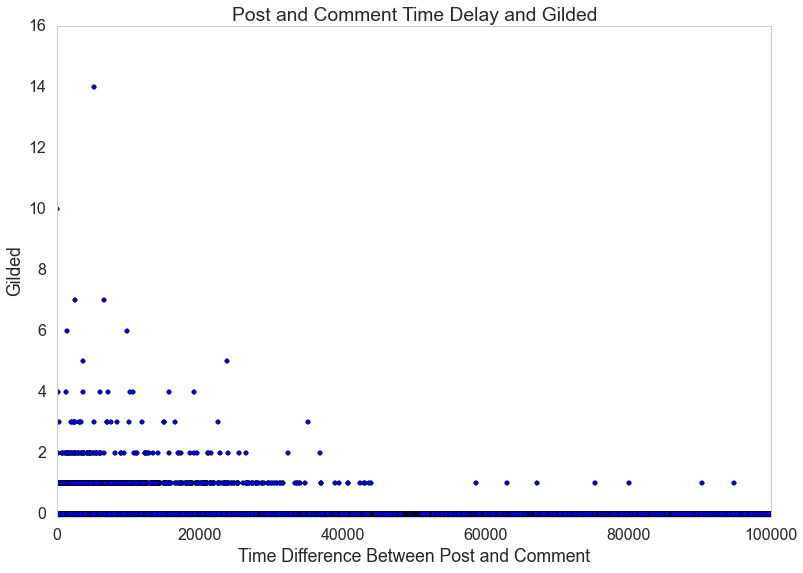

In [21]:
plt.scatter(df['time_delay'], df['gilded']);
plt.xlim(0,100000);
plt.ylim(ymin=-0.1);
plt.title('Post and Comment Time Delay and Gilded');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Gilded');
plt.grid(False)

##Comment Content

###Characters

Next, we can look at the attributes of the body of the comment itself. Here is the **length of each comment** (number of characters) compared to its popularity: 

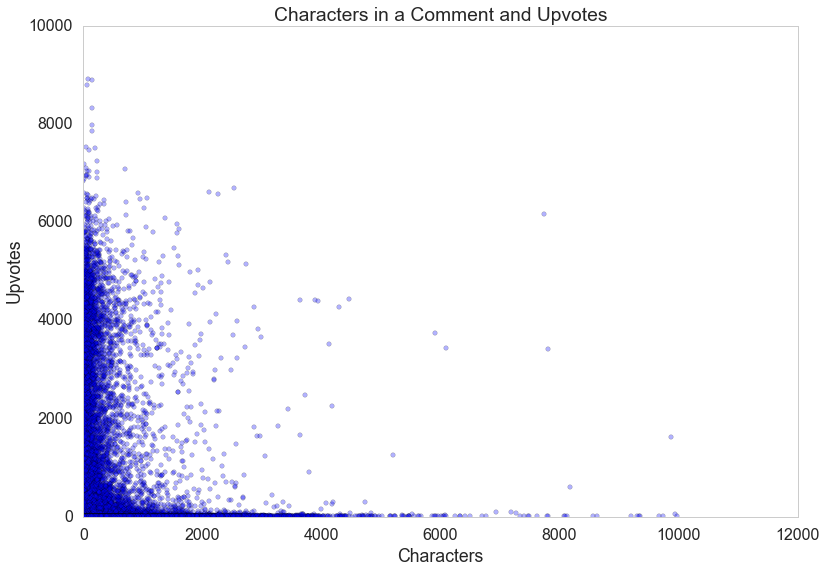

In [22]:
plt.scatter(df['character_count'], df['ups'], alpha=0.3);
plt.ylim(ymin=-0.1);
plt.xlim(xmin=-0.1);
plt.title('Characters in a Comment and Upvotes');
plt.xlabel('Characters');
plt.ylabel('Upvotes');
plt.grid(False)

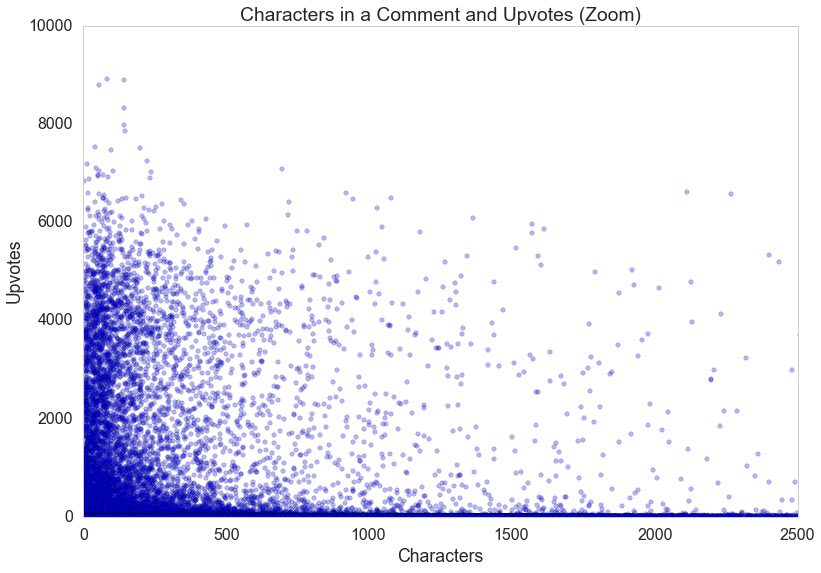

In [23]:
plt.scatter(df['character_count'], df['ups'], alpha=0.3);
plt.xlim(0,2500);
plt.ylim(ymin=-0.1);
plt.title('Characters in a Comment and Upvotes (Zoom)');
plt.xlabel('Characters');
plt.ylabel('Upvotes');
plt.grid(False)

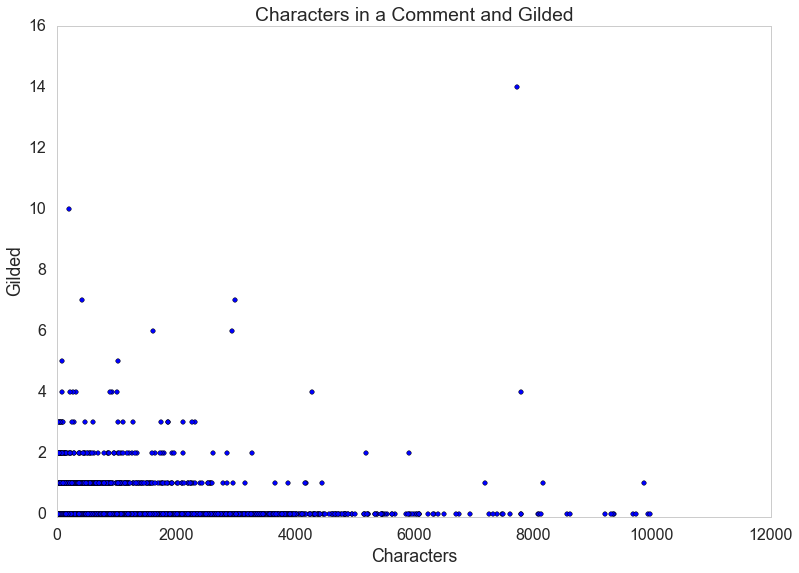

In [24]:
plt.scatter(df['character_count'], df['gilded']);
plt.ylim(ymin=-0.1);
plt.xlim(xmin=-0.1);
plt.title('Characters in a Comment and Gilded');
plt.xlabel('Characters');
plt.ylabel('Gilded');
plt.grid(False);

###Word Count

However, character count can only describe so much. Let's take a look at the word count: 

In [25]:
def word_count(text):
    wordList = re.sub("[^\w]", " ",  text).split()
    return len(wordList)

df['word_count'] = df['body'].map(lambda x : word_count(x))

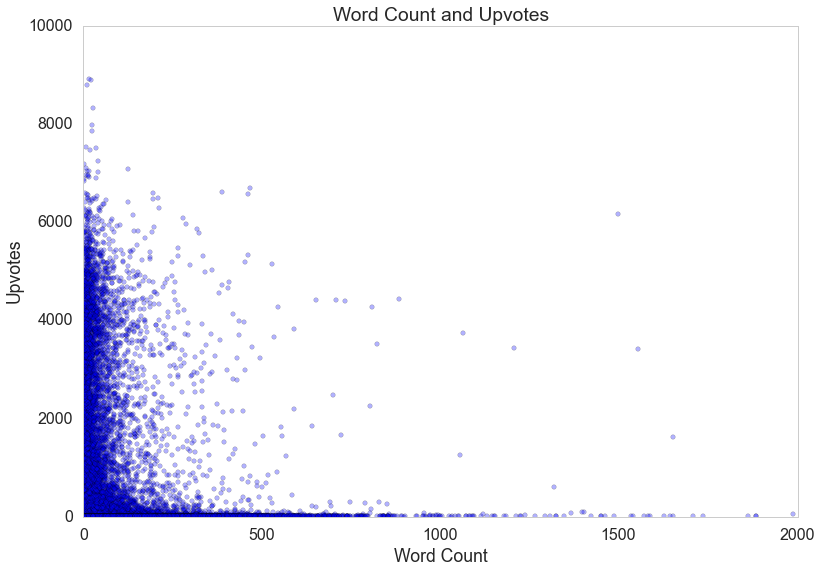

In [26]:
plt.scatter(df['word_count'], df['ups'], alpha=0.3);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Upvotes');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);
plt.grid(False)

Now we can also take a look at the average upvotes a comment will get if it has a certain number of words. 

In [27]:
# create dictionary of word count and upvotes
wcu = {}
wcg = {}
for thread in threads:
    for comment in threads[thread]:
        string = comment.body
        wordList = re.sub("[^\w]", " ",  string).split()
        length = len(wordList)
        if not length in wcu:
            wcu[length] = [comment.ups]
        else:
            wcu[length].append(comment.ups)
        if not length in wcg:
            wcg[length] = [comment.gilded]
        else:
            wcg[length].append(comment.gilded)

# create dictionary of word count and average upvotes
wcu_avg = {}
for key, value in wcu.iteritems():
    wcu_avg[key] = sum(value)/len(value)
    
wcg_avg = {}
for key, value in wcg.iteritems():
    wcg_avg[key] = sum(value)/len(value)
            
sxu = sorted(wcu_avg.items(), key=operator.itemgetter(1))
sxg = sorted(wcg_avg.items(), key=operator.itemgetter(1))

xsu = []
ysu = []
for pair in sxu:
    xsu.append(pair[0])
    ysu.append(pair[1])

xsg = []
ysg = []
for pair in sxg:
    xsg.append(pair[0])
    ysg.append(pair[1])


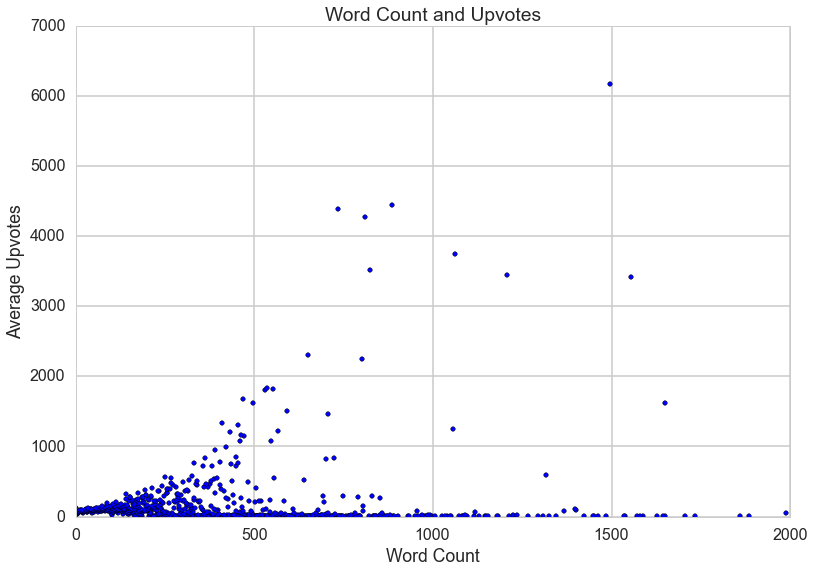

In [28]:
plt.scatter(xsu,ysu);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Average Upvotes');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);

We see some interesting behavior at low word counts where upvotes are fairly predictable. 

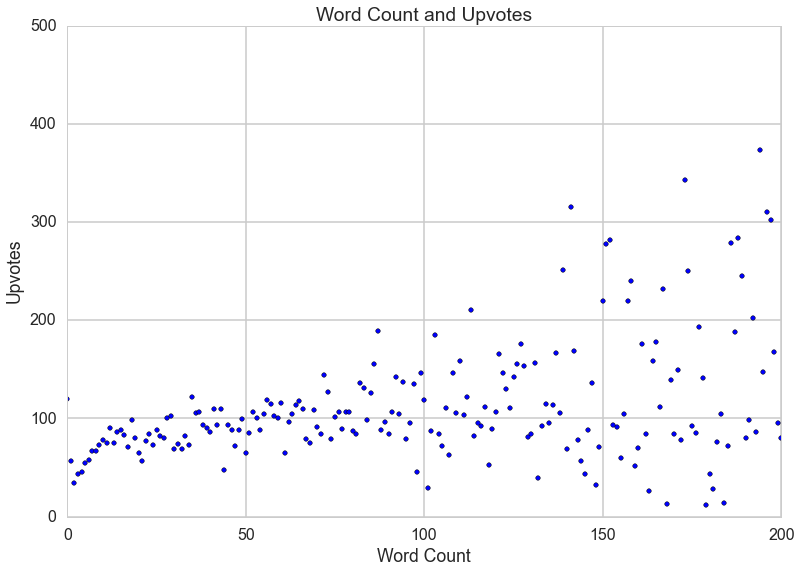

In [29]:
plt.scatter(xsu,ysu);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Upvotes');
plt.xlim(-0.1,200);
plt.ylim(0, 500);

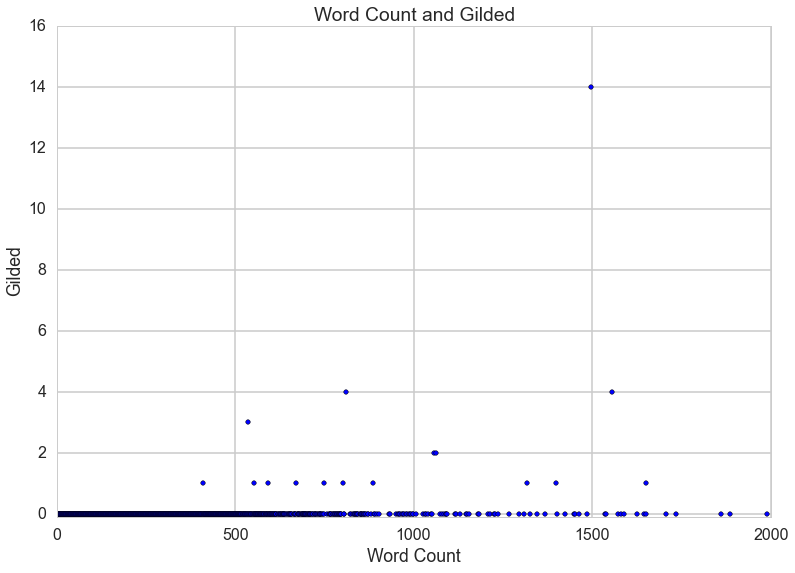

In [30]:
plt.scatter(xsg,ysg);
plt.title('Word Count and Gilded');
plt.xlabel('Word Count');
plt.ylabel('Gilded');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);

###Profanity

In [ ]:
# DO NOT RUN
# code that was used for cleaning the csv file 

sn = []
for swear in SWEARS:
    sn.append(swear[0:-3])
    
with open('profanity.csv', 'wb') as myfile:
    wr = csv.writer(myfile)
    for row in sn:
        wr.writerow([row])

Import a small dictionary of profanity.

In [31]:
import csv

input_file = csv.DictReader(open("profanity.csv"))

SWEARS = []
for row in input_file:
    SWEARS.append(row["swears"])
    

In [32]:
def swear_count(text):
    count = 0
    for swear in SWEARS:
        if swear in text:
            count = count + 1
    return count

df['swear_count'] = df['body'].map(lambda x : swear_count(x))

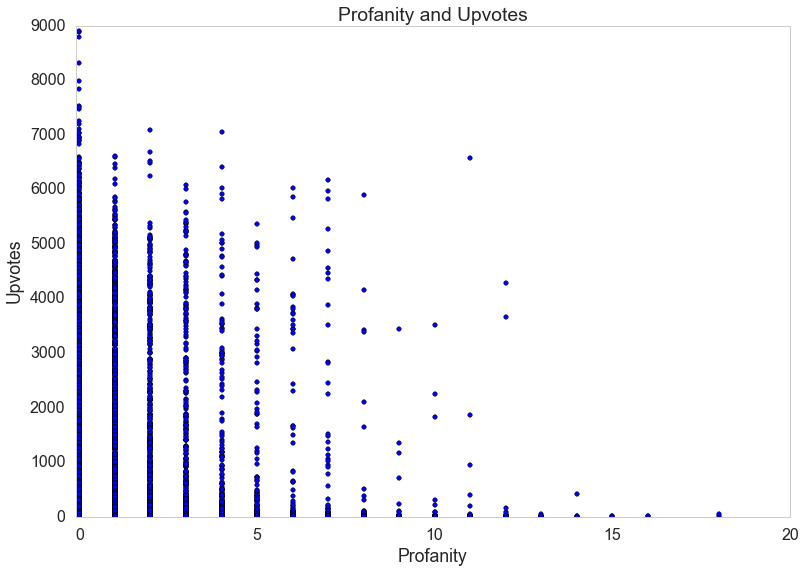

In [33]:
plt.scatter(df['swear_count'], df['ups']);
plt.title('Profanity and Upvotes');
plt.xlabel('Profanity');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);
plt.grid(False)

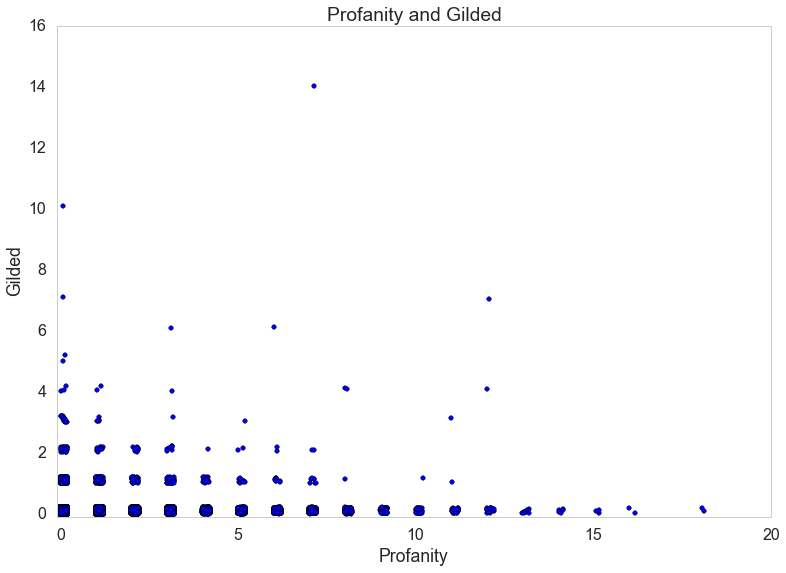

In [34]:
import random

# add some noise so that we can see density of points
noise1 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]
noise2 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]

plt.scatter(np.array(df['swear_count']) + np.array(noise1), np.array(df['gilded']) + np.array(noise2));
plt.title('Profanity and Gilded');
plt.xlabel('Profanity');
plt.ylabel('Gilded');
plt.xlim(-0.1,20);
plt.ylim(-0.1, 16);
plt.grid(False)

###Average Size of Words

In [35]:
def word_size(text):
    words = re.sub("[^\w]", " ",  text).split()
    if len(words) > 0: 
        avg = sum(len(word) for word in words)/len(words)
    else:
        return 0
    return avg

df['word_size'] = df['body'].map(lambda x : word_size(x))

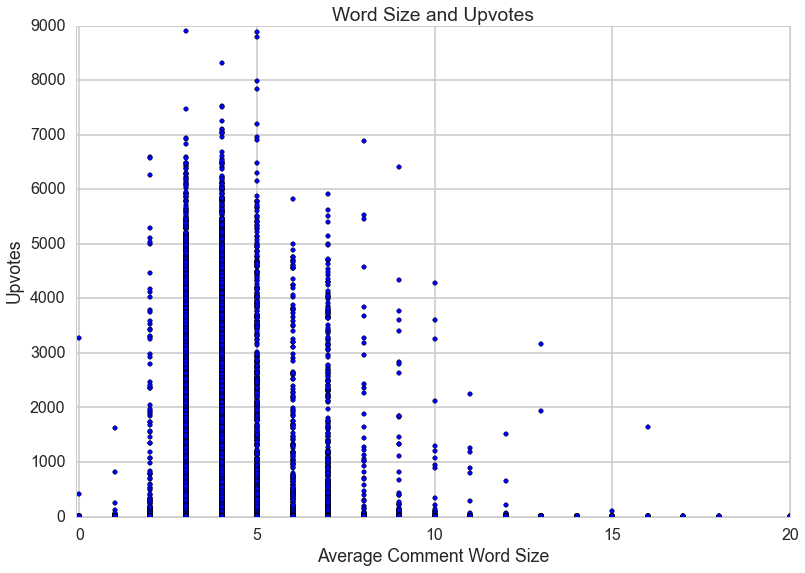

In [36]:
plt.scatter(df['word_size'], df['ups']);
plt.title('Word Size and Upvotes');
plt.xlabel('Average Comment Word Size');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);

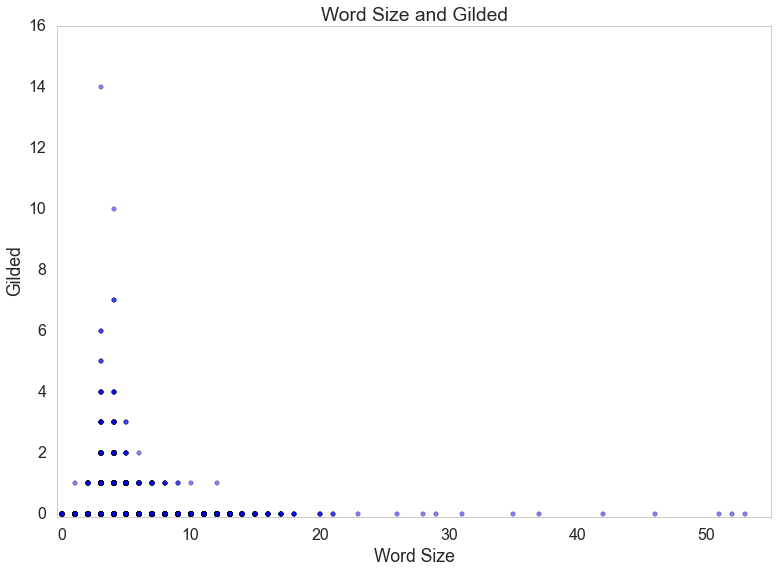

In [37]:
plt.scatter(df['word_size'], df['gilded'], alpha=0.5);
plt.title('Word Size and Gilded');
plt.xlabel('Word Size');
plt.ylabel('Gilded');
plt.xlim(-0.4,55);
plt.ylim(-0.1, 16);
plt.grid(False)

###Links to Outside Information

In [38]:
def link_count(html):
    urls = re.findall('<a href="?\'?([^"\'>]*)', html)
    count = len(urls)
    return count

df['link_count'] = df['body_html'].map(lambda x : link_count(x))

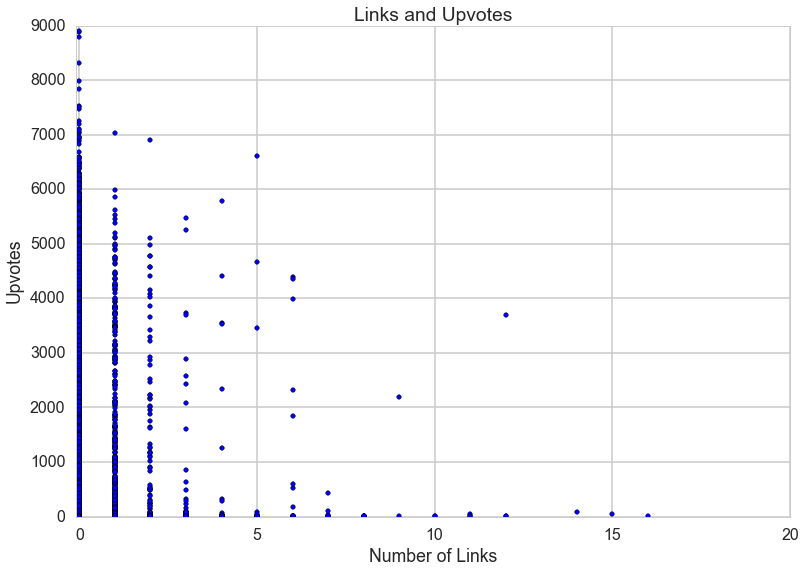

In [39]:
plt.scatter(df['link_count'], df['ups']);
plt.title('Links and Upvotes');
plt.xlabel('Number of Links');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);

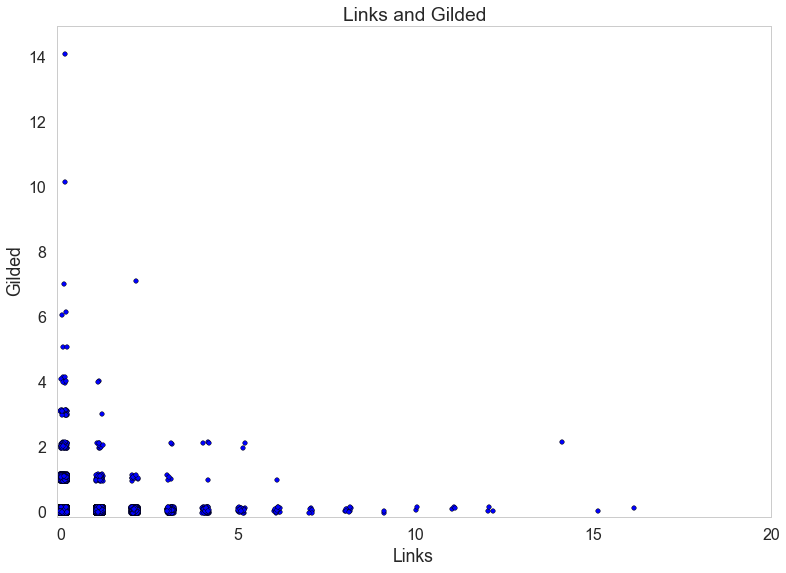

In [40]:
# add some noise so that we can see density of points
noise1 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]
noise2 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]

plt.scatter(np.array(df['link_count']) + np.array(noise1), np.array(df['gilded']) + np.array(noise2));
plt.title('Links and Gilded');
plt.xlabel('Links');
plt.ylabel('Gilded');
plt.xlim(-0.1,20);
plt.ylim(-0.1,15);
plt.grid(False)

###Markdown

Another interesting feature is comment markdown -- comments on reddit can be formatted (ex: bold, strikethrough, quotes) using tags.

In [42]:
# count times italics, bold, strikethrough, blockquote were used
def italics_count(html):
    italics = re.findall('<em>', html)
    count = len(italics)
    return count

def bold_count(html):
    bold = re.findall('<strong>', html)
    count = len(bold)
    return count

def st_count(html):
    st = re.findall('<s>', html)
    count = len(st)
    return count

def bq_count(html):
    bq = re.findall('<blockquote>', html)
    count = len(bq)
    return count

df['italics_count'] = df['body_html'].map(lambda x : italics_count(x))
df['bold_count'] = df['body_html'].map(lambda x : bold_count(x))
df['strikethrough_count'] = df['body_html'].map(lambda x : st_count(x))
df['blockquote_count'] = df['body_html'].map(lambda x : bq_count(x))

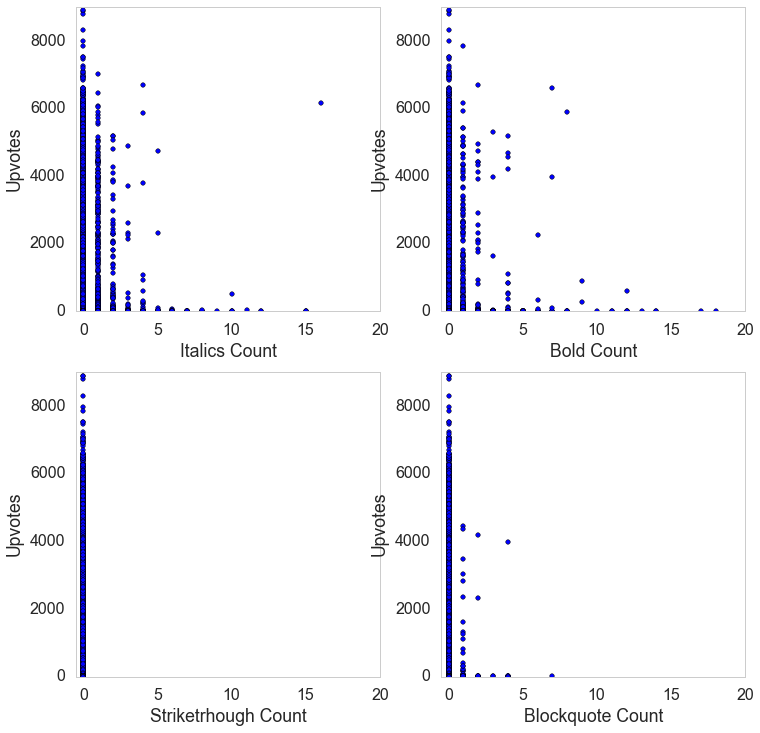

In [43]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

pcols = ['italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count']
names = ['Italics Count', 'Bold Count', 'Striketrhough Count', 'Blockquote Count']

for ax, pcol, name in zip(axes.ravel(), pcols, names):
    
    ax.scatter(df[pcol], df['ups']);
    ax.set_xlabel(name);
    ax.set_ylabel('Upvotes');
    ax.set_xlim(-0.5,20);
    ax.set_ylim(-0.5, 9000);
    ax.grid(False);

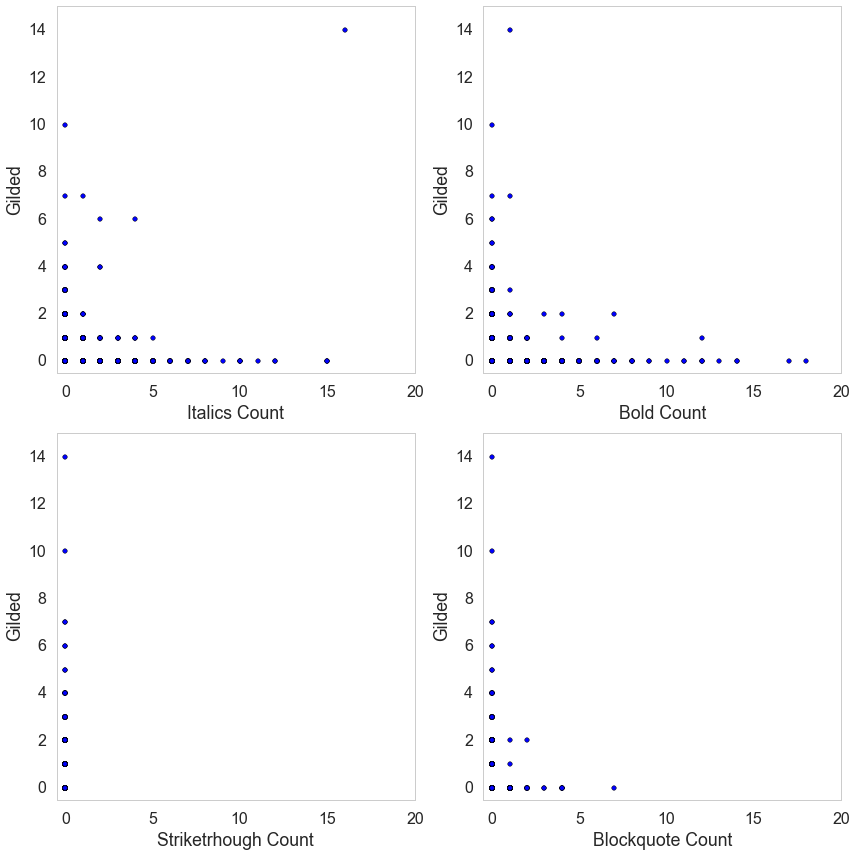

In [45]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), tight_layout=True)

pcols = ['italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count']
names = ['Italics Count', 'Bold Count', 'Striketrhough Count', 'Blockquote Count']

for ax, pcol, name in zip(axes.ravel(), pcols, names):
    
    ax.scatter(df[pcol], df['gilded']);
    ax.set_xlabel(name);
    ax.set_ylabel('Gilded');
    ax.set_xlim(-0.5,20);
    ax.set_ylim(-0.5, 15);
    ax.grid(False)

###Paragraph Count

In [46]:
def p_count(html):
    ps = re.findall('<p>', html)
    count = len(ps)
    return count

df['paragraph_count'] = df['body_html'].map(lambda x : p_count(x))

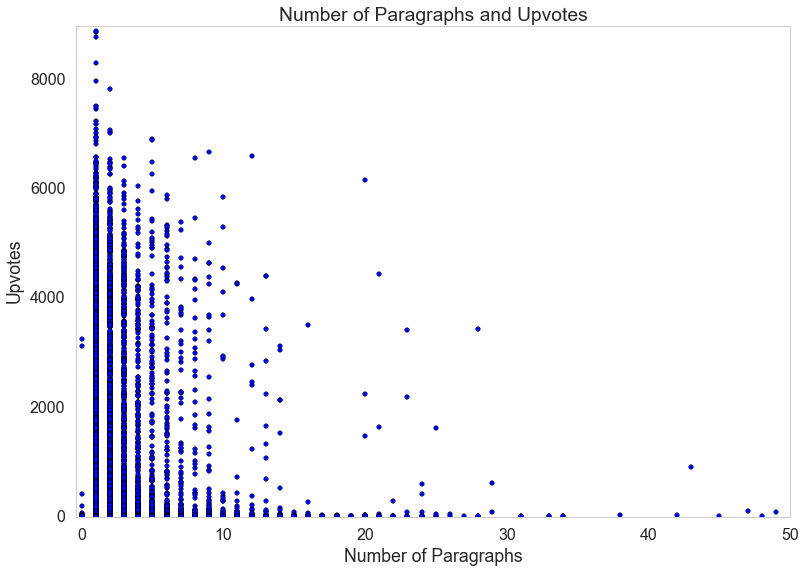

In [47]:
plt.scatter(df['paragraph_count'], df['ups']);
plt.title('Number of Paragraphs and Upvotes');
plt.xlabel('Number of Paragraphs');
plt.ylabel('Upvotes');
plt.xlim(-0.4,50);
plt.ylim(-0.5,9000);
plt.grid(False)

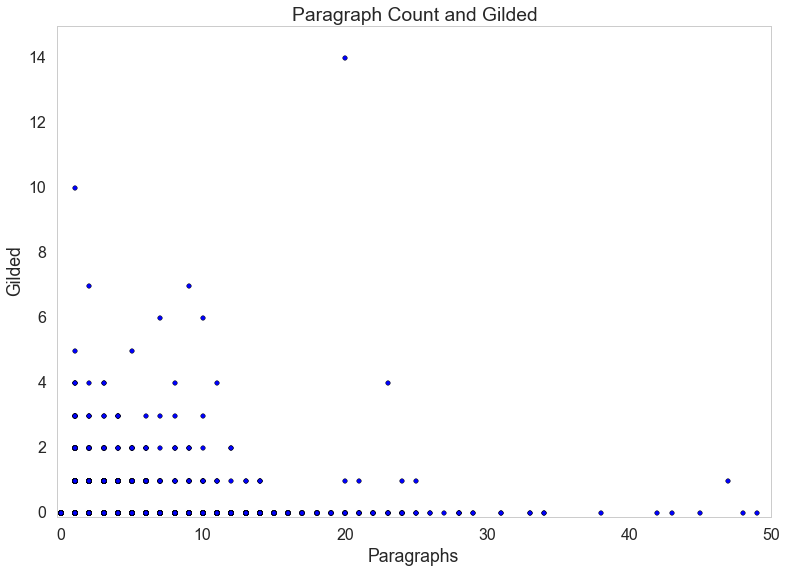

In [49]:
plt.scatter(df['paragraph_count'], df['gilded']);
plt.title('Paragraph Count and Gilded');
plt.xlabel('Paragraphs');
plt.ylabel('Gilded');
plt.xlim(-0.3,50);
plt.ylim(-0.1, 15);
plt.grid(False)

###Comment relevance

Another feature to consider is **relevance** between the comment and the question. We will measure this by the number of synonyms for non-trivial words in the question that the comment has. For example, if the questions is:

"What kind of fun 'poor' experiences do you believe the wealthy are missing out on?"

some examples of non-trivial words are "kind," "fun," "experiences," "wealthy," and "poor." We then find synonyms for each of these words, and search for the number of times these synonyms appear in each comment for a relevance score. 

First, let's get all 100 questions, and filter out all the question and trivial words. We will then create a dictionary that has the question as the key, and the list of synonyms as the value.

In [51]:
import string
titles_orig = list(set([str(x.title) for x in df._submission]))
titles = [x.translate(None, string.punctuation).lower() for x in titles_orig]
question_words = ['who', 'whos', 'whose', 'what', 'whats', 'where', 'wheres', 'when', 'whens', 'why', 'how', 'hows']
trivial_words = ['that', 'have', 'been', 'should', 'your', 'youre', 'were', 'with', 'does',
                 'youve', 'about', 'wasnt', 'dont', 'just', 'from', 'this', 'could']

titles_list = [x.split() for x in titles]

# remove length 1, 2, and 3 words, and words from question_words and trivial_words
filtered_titles = [[x for x in elt if len(x) > 3 and x not in question_words and x not in trivial_words] for elt in titles_list]

print titles_orig[0]
print filtered_titles[0]

What issue IS black and white to you?
['issue', 'black', 'white']


Then, let's find the synonyms for each of these questions, and create the dictionary. We will find synonyms using NLTK (Natural Language ToolKit). 

In [53]:
import nltk
from nltk.corpus import wordnet

synonyms_d = {}

for i in range(len(titles_orig)):
    synonyms = []
    for word in filtered_titles[i]:
        for ss in wordnet.synsets(word):
            syn_list_spaces = [str(x).replace('_', ' ') for x in ss.lemma_names()]
            synonyms += syn_list_spaces
    synonyms_d[titles_orig[i]] = set(synonyms)

print filtered_titles[5]
print synonyms_d[titles_orig[5]]

['movie', 'oneliner', 'repeatedly', 'real', 'life']
set(['flick', 'motion-picture show', 'pic', 'substantial', 'moving-picture show', 'lifetime', 'real number', 'life-time', 'film', 'really', 'living', 'genuine', 'movie', 'life story', 'liveliness', 'literal', 'animation', 'biography', 'life history', 'real', 'picture', 'life', 'sprightliness', 'moving picture', 'very', 'material', 'veridical', 'repeatedly', 'rattling', 'actual', 'spirit', 'tangible', 'life sentence', 'lifespan', 'existent', 'motion picture', 'aliveness', 'picture show'])


Now, for each entry in our dataframe, let's calculate: 
* number of occurrences of the question's synonyms (stored in column ```syn_count```) in the comment body
* proportion of the comment that is synonyms of the question (stored in column ```syn_perc```)

In [54]:
syn_number = []
syn_proportion = []

for index, row in df.iterrows():
    synonyms = synonyms_d[str(row._submission.title)]
    comment_list = [x.encode("utf-8") for x in row.body.split()]
    if len(comment_list) == 0:
        syn_number.append(0)
        syn_proportion.append(0.)
        continue
    count = sum([1 for word in comment_list if word in synonyms])
    syn_number.append(count)
    syn_proportion.append(float(count)/float(len(comment_list)))

df['syn_count'] = syn_number
df['syn_perc'] = syn_proportion

Below is a graph of the relationship between number of upvotes and synonym count. The more high scoring comments seem to have fewer synonyms, though this could be merely due to count (most comments don't have many synonyms).

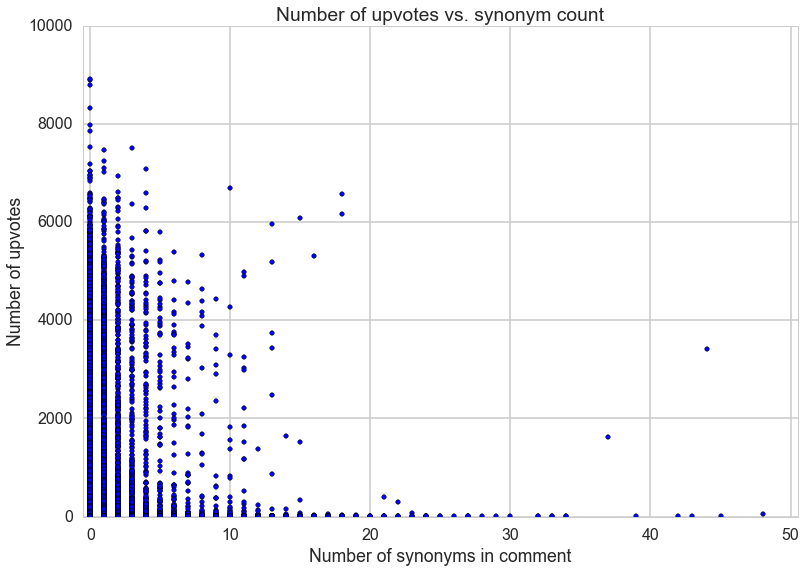

In [55]:
plt.scatter(df['syn_count'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([-0.5, 50.5])
plt.title('Number of upvotes vs. synonym count')
plt.xlabel('Number of synonyms in comment')
plt.ylabel('Number of upvotes')

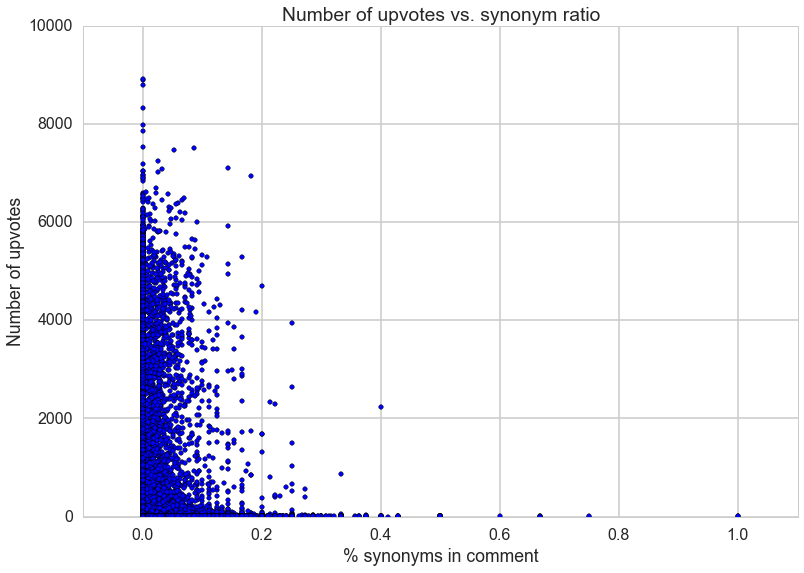

In [57]:
plt.scatter(df['syn_perc'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([-0.1, 1.1])
plt.title('Number of upvotes vs. synonym ratio')
plt.xlabel('% synonyms in comment')
plt.ylabel('Number of upvotes')

Again, we see a trend similar to the first graph: more high scoring comments seem to have a smaller synonym percentage, though again, this could be merely due to count.

###Author Username Features

A valid username in Reddit can only have 3-20 characters out of A-Z, a-z, 0-9, underscores (_), and dashes (-). 

The following features are potentially interesting:

1. ```un_length```: Username length
2. ```un_punc```: Username punctuation:
  * 0: no underscores or dashes
  * 1: only one of underscores or dashes
  * 2: both underscores and dashes
3. ```un_case```: Letter cases
  * 0: only lowercase letters
  * 1: only uppercase letters
  * 2: both uppercase and lowercase letters
4. ```un_number```: Ratio of username that is numbers
5. Special usernames:
  * ```un_PM```: "PM_(x)" usernames
  * ```un_bot```: Contains "bot"

In [58]:
df['un_length'] = df['author'].map(lambda x : len(str(x)))

In [59]:
def un_punc (text):
    total = 0
    if '_' in text: total += 1
    if '-' in text: total += 1
    return total

df['un_punc'] = df['author'].map(lambda x : un_punc(str(x)))

In [60]:
def un_case (text):
    if text.islower(): return 0
    if text.isupper(): return 1
    return 2

df['un_case'] = df['author'].map(lambda x : un_case(str(x)))

In [61]:
def un_number (text):    
    numbers = sum(c.isdigit() for c in text)
    return float(numbers)/float(len(text))

df['un_number'] = df['author'].map(lambda x : un_number(str(x)))

In [62]:
df['un_PM'] = df['author'].map(lambda x : 1 if str(x)[:3] == "PM_" else 0)
df['un_bot'] = df['author'].map(lambda x : 1 if 'bot' in str(x).lower() else 0)

###Analysis of Author Features
**Disclaimer**: Note that the below are all shallow, preliminary observations: in fact, combinations, rather than a single feature observations, will be more telling (which is the purpose of machine learning!). 

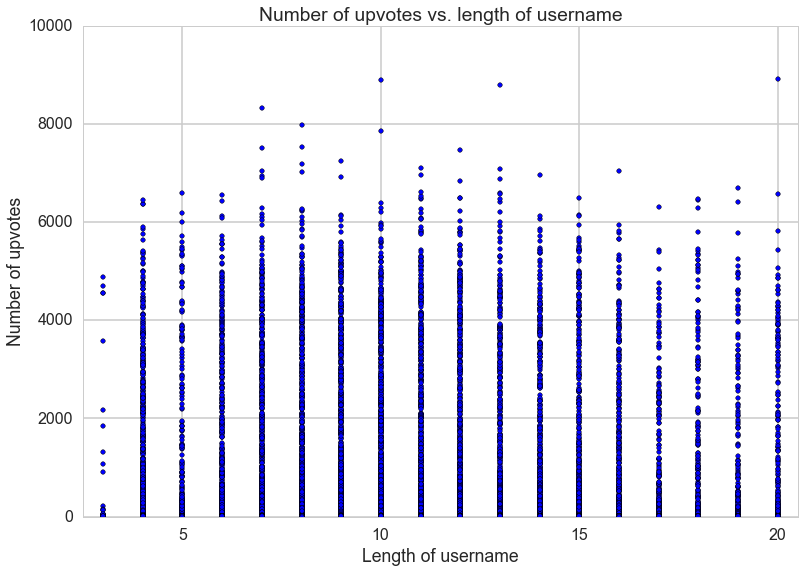

In [63]:
plt.scatter(df['un_length'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([2.5, 20.5])
plt.title('Number of upvotes vs. length of username')
plt.xlabel('Length of username')
plt.ylabel('Number of upvotes')

From the above, there does not seem to be a trend between number of upvotes and length of username.

In [69]:
print "Baseline average # of upvotes:", np.mean(df.ups)
print "Standard deviation:", np.std(df.ups)

Baseline average # of upvotes: 80.8764642655
Standard deviation: 498.146323004


In [68]:
print "Username punctuation averages:"
print "________________________________"
print "# of usernames with no punctuation:", len(df[df['un_punc'] == 0])
print "Average upvotes:", np.mean(df[df['un_punc'] == 0].ups)
print "Sample standard deviation:", np.std(df[df['un_punc'] == 0].ups)
print "________________________________"
print "# of usernames with underscores or dashes:", len(df[df['un_punc'] == 1])
print "Average upvotes:", np.mean(df[df['un_punc'] == 1].ups)
print "Sample standard deviation:", np.std(df[df['un_punc'] == 1].ups)
print "________________________________"
print "# of usernames with both underscores and dashes:", len(df[df['un_punc'] == 2])
print "Average upvotes:", np.mean(df[df['un_punc'] == 2].ups)
print "Sample standard deviation:", np.std(df[df['un_punc'] == 2].ups)

Username punctuation averages:
________________________________
# of usernames with no punctuation: 142246
Average upvotes: 79.1228575847
Sample standard deviation: 491.9646255
________________________________
# of usernames with underscores or dashes: 22220
Average upvotes: 91.9317281728
Sample standard deviation: 535.70604334
________________________________
# of usernames with both underscores and dashes: 207
Average upvotes: 99.2125603865
Sample standard deviation: 519.852118731


Most of the usernames have no punctuation. There is a trend towards more punctuation, more upvotes. Usernames with no punctuation do worse than average.

In [72]:
print "Username case averages:"
print "________________________________"
print "# of usernames with all lowercase:", len(df[df['un_case'] == 0])
print "Average upvotes:", np.mean(df[df['un_case'] == 0].ups)
print "Sample standard deviation:", np.std(df[df['un_case'] == 0].ups)
print "________________________________"
print "# of usernames with all uppercase:", len(df[df['un_case'] == 1])
print "Average upvotes:", np.mean(df[df['un_case'] == 1].ups)
print "Sample standard deviation:", np.std(df[df['un_case'] == 1].ups)
print "________________________________"
print "# of usernames with both lower and uppercase:", len(df[df['un_case'] == 2])
print "Average upvotes:", np.mean(df[df['un_case'] == 2].ups)
print "Sample standard deviation:", np.std(df[df['un_case'] == 2].ups)

Username case averages:
________________________________
# of usernames with all lowercase: 76808
Average upvotes: 77.7859728153
Sample standard deviation: 493.294272261
________________________________
# of usernames with all uppercase: 2782
Average upvotes: 87.417325665
Sample standard deviation: 503.500019627
________________________________
# of usernames with both lower and uppercase: 85083
Average upvotes: 83.4525110774
Sample standard deviation: 502.295152323


Most usernames have a mixture of lower and uppercase letters. The usernames with all lowercase letters score lowest, while the usernames with all uppercase letters score highest.

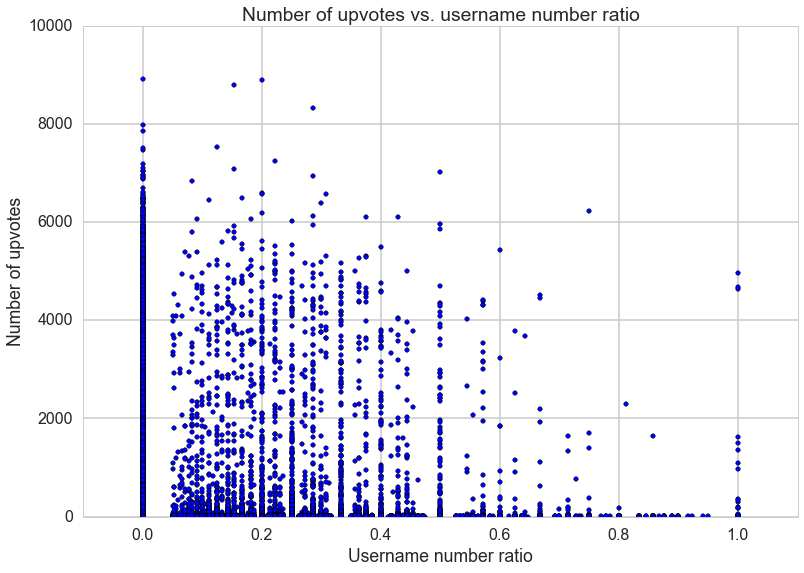

In [73]:
plt.scatter(df['un_number'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([-0.1, 1.1])
plt.title('Number of upvotes vs. username number ratio')
plt.xlabel('Username number ratio')
plt.ylabel('Number of upvotes')

From the above, there does not seem to be a relationship between upvotes and username number ratio. It is clear, thought, that most authors do not have numbers in their username. 

In [74]:
print "Special username averages:"
print "________________________________"
print "# of usernames with PM_(x):", len(df[df['un_PM'] == 1])
print "Average upvotes:", np.mean(df[df['un_PM'] == 1].ups)
print "Sample standard deviation:", np.std(df[df['un_PM'] == 1].ups)
print "________________________________"
print "# of usernames w/o PM_(x):", len(df[df['un_PM'] == 0])
print "Average upvotes:", np.mean(df[df['un_PM'] == 0].ups)
print "Sample standard deviation:", np.std(df[df['un_PM'] == 0].ups)
print "________________________________"
print "# of usernames with bot:", len(df[df['un_bot'] == 1])
print "Average upvotes:", np.mean(df[df['un_bot'] == 1].ups)
print "Sample standard deviation:", np.std(df[df['un_bot'] == 1].ups)
print "________________________________"
print "# of usernames w/o bot:", len(df[df['un_bot'] == 0])
print "Average upvotes:", np.mean(df[df['un_bot'] == 0].ups)
print "Sample standard deviation:", np.std(df[df['un_bot'] == 0].ups)

Special username averages:
________________________________
# of usernames with PM_(x): 279
Average upvotes: 140.913978495
Sample standard deviation: 586.489489178
________________________________
# of usernames w/o PM_(x): 164394
Average upvotes: 80.7745720647
Sample standard deviation: 497.976918082
________________________________
# of usernames with bot: 448
Average upvotes: 64.6830357143
Sample standard deviation: 427.14576748
________________________________
# of usernames w/o bot: 164225
Average upvotes: 80.9206393667
Sample standard deviation: 498.325454779


There are not many "PM_(x)" usernames, but those with this username have double the baseline average number of upvotes. However, if the username contains "bot," the user gets significantly fewer than average number of upvotes.

###Finishing up

Let's finish building the dataframe by turning certain variables into indicator variables.

In [50]:
df['i_author_flair_css_class']=(df.author_flair_css_class.notnull())*1
del df['author_flair_css_class']
df['i_author_flair_text']=(df.author_flair_text.notnull())*1
del df['author_flair_text']
df['i_distinguished']=(df.distinguished.notnull())*1
del df['distinguished']
df['i_edited']=(df.edited)*1
del df['edited']
df['i_score_hidden']=(df.score_hidden)*1
del df['score_hidden']
df['i_banned_by']=(df.banned_by.notnull())*1
del df['banned_by']

In [76]:
df.head(3)

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by,syn_count,syn_perc,un_length,un_punc,un_case,un_number,un_PM,un_bot
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,0,0,2485,AskReddit,36ih74,2485,60,7011,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,14,0,2,0.000000,0,0
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,0,1,4983,AskReddit,36ih74,4983,63,3024,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,2,0.333333,0,0
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,0,0,2386,AskReddit,36ih74,2386,46,6330,10,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,0,0,0.000000,0,0


Features:

* Character count [DONE]
* Word count [DONE]
* Time created [DONE]
* Time delay [DONE]
* Swear words [DONE]
* Average size of words [DONE]
* Links included in comment [DONE]
* Markdown used [DONE]
* Paragraph count [DONE]
* Author username [DONE]
* Relevance in vocabulary to original post [DONE]

Now, let's pickle this dataframe to be used for the next step: Supervised Learning.

In [77]:
cPickle.dump(df, open('df_features.p', 'wb'))
df_test = cPickle.load(open('df_features.p', 'rb'))
df_test.head(3)

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by,syn_count,syn_perc,un_length,un_punc,un_case,un_number,un_PM,un_bot
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,0,0,2485,AskReddit,36ih74,2485,60,7011,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,14,0,2,0.000000,0,0
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,0,1,4983,AskReddit,36ih74,4983,63,3024,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,2,0.333333,0,0
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,0,0,2386,AskReddit,36ih74,2386,46,6330,10,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,0,0,0.000000,0,0
